## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import skimage
import os
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from pytorch_msssim import ssim

## Input

In [2]:
DATA_ROOT = 'Data/NL_SIM/'
# 4 classes (4 types of cellular structures)
DATA_NAMES = ['ccp', 'er', 'factin', 'microtubules']

NUM_SAMPLES_PER_TYPE = 50
FRAMES = 25
IM_DIM = 480

N_TEST_PER_TYPE = 10
SEED = 42


## Train Test Split

Idea: The samples in the dataset were imported subfolder by subfolder for each type (ccp, er, factin, microtubular), with 50 samples per type. We randomly choose 10 samples (20%) for each of the blocks of 50 samples. This way, we have all types represented evenly in the train and test dataset

In [3]:
#train test split

def stratified_block_split(
    n_types,
    samples_per_type,
    n_test_per_type,
    seed=42
):
    np.random.seed(seed)

    train_idx = []
    test_idx = []

    for t in range(n_types):
        start = t * samples_per_type
        end = start + samples_per_type

        block = np.arange(start, end)
        test = np.random.choice(block, n_test_per_type, replace=False)
        train = np.setdiff1d(block, test)

        train_idx.extend(train)
        test_idx.extend(test)

    return np.array(train_idx), np.array(test_idx)


In [4]:
train_idx, test_idx = stratified_block_split(
    n_types=4,
    samples_per_type=NUM_SAMPLES_PER_TYPE,
    n_test_per_type=N_TEST_PER_TYPE,
    seed=SEED
)


## Data Set (Lazy Loading) including Normalization

In [5]:
class NL_SIM_Dataset(Dataset):
    def __init__(self, indices):
        self.indices = indices
        self.mapping = []
        for idx in indices:
            data_type = idx // NUM_SAMPLES_PER_TYPE
            local_idx = idx % NUM_SAMPLES_PER_TYPE + 1
            self.mapping.append((DATA_NAMES[data_type], local_idx))

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        data_name, i = self.mapping[idx]

        # ---------- Low resolution input ----------
        lr_path = os.path.join(DATA_ROOT, data_name, 'low_res', f'{i}.png')
        lr = cv2.imread(lr_path, 0)
        lr = cv2.resize(lr, (IM_DIM, IM_DIM), interpolation=cv2.INTER_CUBIC)
        lr = lr.astype(np.float32) / 255.0
        lr_tensor = torch.from_numpy(lr).unsqueeze(0)  # (1,H,W)

        # ---------- Ground truth ----------
        gt_path = os.path.join(DATA_ROOT, data_name, 'ground_truth', f'{i}.png')
        gt = cv2.imread(gt_path, 0)
        gt = cv2.resize(gt, (IM_DIM, IM_DIM), interpolation=cv2.INTER_CUBIC)
        gt = gt.astype(np.float32) / 255.0
        gt_tensor = torch.from_numpy(gt).unsqueeze(0)  # (1,H,W)

        # ---------- Optional: Input Frames & Patterns ----------
        # Input Frames
        input_stack = np.zeros((FRAMES, IM_DIM, IM_DIM), dtype=np.float32)
        for j in range(1, FRAMES+1):
            path = os.path.join(DATA_ROOT, data_name, 'input_frames', f'{i}_{j}.png')
            img = cv2.imread(path, 0)
            img = cv2.resize(img, (IM_DIM, IM_DIM), interpolation=cv2.INTER_CUBIC)
            input_stack[j-1] = img / 255.0
        input_frames_tensor = torch.from_numpy(input_stack)  # (F,H,W)


        return lr_tensor, gt_tensor, input_frames_tensor



## Data Loader

In [6]:
BATCH_SIZE = 1      # adjust if desired

train_dataset = NL_SIM_Dataset(train_idx)
test_dataset  = NL_SIM_Dataset(test_idx)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    pin_memory=False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=False
)



In [7]:
# Check
inputs, gt, lr = next(iter(train_loader))

print("Input:", inputs.shape)   # Input = low resolution image, (B, 1, 480, 480)
print("GT   :", gt.shape)       # GT = ground truth, (B, 1, 480, 480)
print("LR   :", lr.shape)       # LR = low resolution images with different illumination patterns, 25 images per sample, (B, 25, 480, 480)


Input: torch.Size([1, 1, 480, 480])
GT   : torch.Size([1, 1, 480, 480])
LR   : torch.Size([1, 25, 480, 480])


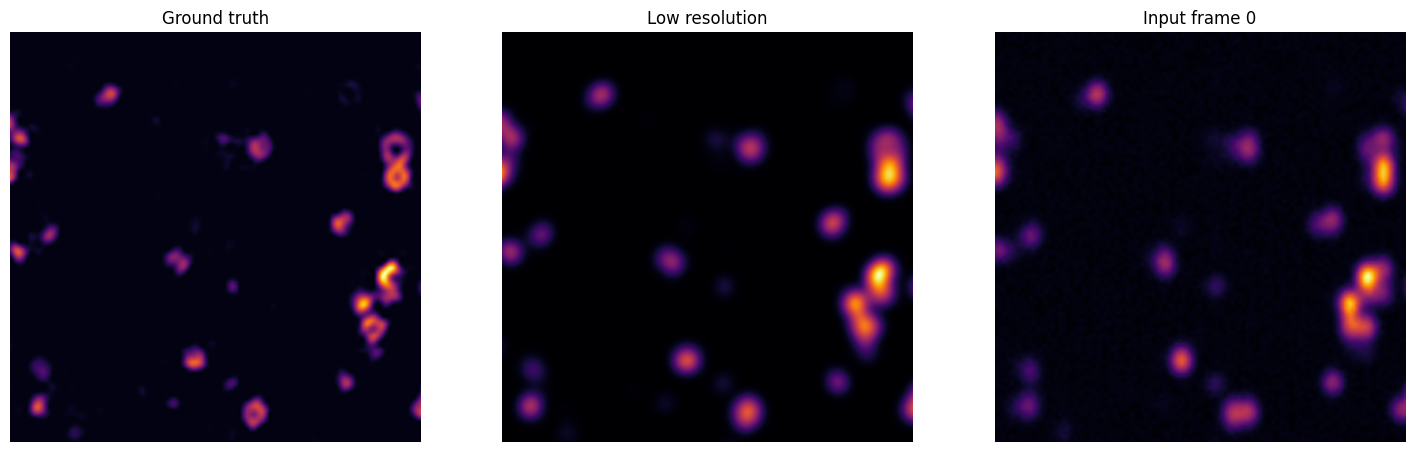

In [8]:


# ----------------------------
# Pick sample
# ----------------------------
ind = 0
lr, gt, input_frames = train_dataset[ind]

# ----------------------------
# Convert to NumPy array
# ----------------------------
lr_np = lr.squeeze(0).numpy()           # (H,W)
gt_np = gt.squeeze(0).numpy()           # (H,W)
frame_np = input_frames[0].numpy()      # erstes Input-Frame (H,W)

# ----------------------------
# Cropping
# ----------------------------
crop = 20
lr_np = lr_np[crop:-crop, crop:-crop]
gt_np = gt_np[crop:-crop, crop:-crop]
frame_np = frame_np[crop:-crop, crop:-crop]

# ----------------------------
# Normalization
# ----------------------------
def norm01(x):
    return (x - x.min()) / (x.max() - x.min() + 1e-8)

lr_np = norm01(lr_np)
gt_np = norm01(gt_np)
frame_np = norm01(frame_np)

# ----------------------------
# Plot
# ----------------------------
plt.figure(figsize=(18,6))

plt.subplot(1,3,1)
plt.imshow(gt_np, cmap='inferno')
plt.title('Ground truth')
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(lr_np, cmap='inferno')
plt.title('Low resolution')
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(frame_np, cmap='inferno')
plt.title('Input frame 0')
plt.axis('off')

plt.show()


## Conversion to Frequency Domain

In [9]:

def to_frequency_domain(input_tensor):
    """
    converts input tensor to frequency omain.

    input_tensor: Torch Tensor in shape (B, 1, H, W) r (B, F, H, W)
    returns complex tensor in same shape (B, H, W) or (B, F, H, W)
    """
    # if input has multiple frames: assumed (B, F, H, W)
    if input_tensor.ndim == 4:  # (B, 1, H, W)
        # FFT entlang H und W
        freq = torch.fft.fft2(input_tensor.squeeze(1))
    elif input_tensor.ndim == 5:  # (B, F, H, W)
        freq = torch.fft.fft2(input_tensor)
    else:
        raise ValueError("Input Tensor must be 4D or 5D")

    return freq


## Loss Functions

### Regular Loss Function (Frequency Domain)

In [10]:
def freq_mse_loss(pred_freq, gt_freq):
    """
    MSE in frequency domain without PSF.
    pred_freq, gt_freq: complex tensors (B, H, W) or (B, F, H, W)
    """
    return torch.mean(torch.abs(pred_freq - gt_freq)**2)


### Radial Loss

In [21]:
def fft_log_mag_from_freq(freq):
    # freq: (B,H,W)complex
    mag = torch.log1p(torch.abs(freq))
    return mag


In [22]:
def radial_profile_torch(mag):
    """
    mag: (B,H,W) real
    returns: (B,R) radial mean profile
    """
    B, H, W = mag.shape
    cy, cx = H // 2, W // 2

    y, x = torch.meshgrid(
        torch.arange(H, device=mag.device),
        torch.arange(W, device=mag.device),
        indexing='ij'
    )
    r = torch.sqrt((x - cx)**2 + (y - cy)**2).long()

    r_flat = r.view(-1)
    max_r = r_flat.max().item() + 1

    profiles = []

    for b in range(B):
        mag_flat = mag[b].view(-1)
        sum_r = torch.zeros(max_r, device=mag.device)
        cnt_r = torch.zeros(max_r, device=mag.device)

        sum_r.scatter_add_(0, r_flat, mag_flat)
        cnt_r.scatter_add_(0, r_flat, torch.ones_like(mag_flat))

        profiles.append(sum_r / (cnt_r + 1e-8))

    return torch.stack(profiles)


### Amplitude and Phase Loss separated (Frequency Domain)

In [11]:
def freq_amp_phase_loss(pred_freq, gt_freq, eps=1e-8):
    pred_amp = torch.abs(pred_freq)
    gt_amp = torch.abs(gt_freq)

    amp_mse = torch.mean((pred_amp - gt_amp)**2, dim=(1,2))
    amp_norm = torch.mean(gt_amp**2, dim=(1,2)) + eps
    amp_loss = amp_mse / amp_norm              # ≈ [0,1]

    # ---------- Phase ----------
    pred_phase = torch.angle(pred_freq)
    gt_phase   = torch.angle(gt_freq)

    # 1 - cos(Δφ) ∈ [0,2]
    phase_loss = torch.mean(1 - torch.cos(pred_phase - gt_phase), dim=(1,2))
    phase_loss = phase_loss / 2.0               # → [0,1]

    return torch.mean(0.9 * amp_loss + 0.1 * phase_loss)


def freq_amp_loss(pred_freq, gt_freq, eps=1e-8):
    pred_amp = torch.abs(pred_freq)
    gt_amp   = torch.abs(gt_freq)

    # Log-compression
    pred_amp = torch.log1p(pred_amp)
    gt_amp   = torch.log1p(gt_amp)

    amp_l1 = torch.mean(torch.abs(pred_amp - gt_amp))
    return amp_l1


### Loss Function (Frequency Domain)

In [12]:
def freq_loss(pred_freq, gt_freq):
    """
    Pure Frequency-Domain Loss (no PSF).

    pred_freq: FFT(Network Output) -> (B,H,W), complex
    gt_freq: FFT(Ground Truth)   -> (B,H,W), complex
    """
    eps = 1e-8

    # MSE per batch element
    mse = torch.mean(torch.abs(pred_freq - gt_freq)**2, dim=(1,2))  # (B,)

    # Normalize by GT energy (keeps loss scale stable)
    norm_factor = torch.mean(torch.abs(gt_freq)**2, dim=(1,2)) + eps  # (B,)

    loss = torch.mean(mse / norm_factor)  # scalar, ~0–1
    return loss


### Loss Function (similar to Zach T. Burns) - Pixel Domain

In [13]:
def SSIM_Loss(y_true, y_pred):
    """
    SSIM Loss for PyTorch
    y_true, y_pred: (B,1,H,W), values in range [0,1]
    """
    return 1 - ssim(y_pred, y_true, data_range=1.0, size_average=True)



def Physics_Loss(y_true, y_pred, psf, patterns):
    """
    Physics Loss in PyTorch
    y_true, y_pred: (B,1,H,W), float32 [0,1]
    psf: (H_psf,W_psf)
    patterns: (F,H,W)
    """
    B, _, H, W = y_pred.shape
    F_num = patterns.shape[0]  # number of patterns
    device = y_pred.device

    # PSF as Conv2d-Kernel
    psf_tensor = torch.from_numpy(psf).float().unsqueeze(0).unsqueeze(0).to(device)  # (1,1,H_psf,W_psf)
    patterns_tensor = torch.from_numpy(patterns).float().to(device)  # (F,H,W)

    loss = 0.0

    for b in range(B):
        pred = y_pred[b]        # (1,H,W)
        pred = pred.repeat(F_num,1,1)  # (F,H,W) broadcast for all patterns
        prod = pred * patterns_tensor   # multiply elementwise

        # convolution with PSF
        prod = prod.unsqueeze(1)         # (F,1,H,W)
        conv = F.conv2d(prod, psf_tensor, padding='same')  # (F,1,H,W)
        conv = conv.squeeze(1)           # (F,H,W)

        # Normalization to range  [0,1]
        conv = (conv - conv.min()) / (conv.max() - conv.min() + 1e-8)

        true = y_true[b].repeat(F_num,1,1)  # (F,H,W)
        conv = conv.unsqueeze(1)  # (F,1,H,W)
        true = true.unsqueeze(1)  # (F,1,H,W)

        # SSIM per pattern
        loss += SSIM_Loss(true, conv)

    return loss / B


## Model

In [14]:
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, n_convs=2):
        super().__init__()
        layers = []
        for i in range(n_convs):
            layers.append(nn.Conv2d(
                in_ch if i == 0 else out_ch,
                out_ch,
                kernel_size=3,
                padding=1
            ))
            layers.append(nn.ReLU(inplace=True))
        self.block = nn.Sequential(*layers)

    def forward(self, x):
        return self.block(x)


In [15]:
class FrequencyUNet(nn.Module):
    """

    input_type:
        'mag'       -> 1 channel
        'real_imag' -> 2 channels
    """
    def __init__(self, input_type='real_imag'):
        super().__init__()

        if input_type == 'mag':
            in_ch = 1
        elif input_type == 'real_imag':
            in_ch = 2
        else:
            raise ValueError("input_type must be 'mag' or 'real_imag' ")

        self.input_type = input_type

        # -------- Encoder --------
        self.enc1 = ConvBlock(in_ch, 32, n_convs=3)
        self.enc2 = ConvBlock(32, 64, n_convs=2)
        self.enc3 = ConvBlock(64, 128, n_convs=2)
        self.enc4 = ConvBlock(128, 256, n_convs=2)

        self.pool = nn.MaxPool2d(2)

        # -------- Decoder --------
        self.up1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        self.dec1 = ConvBlock(256 + 128, 128, n_convs=2)

        self.up2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        self.dec2 = ConvBlock(128 + 64, 64, n_convs=2)

        self.up3 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        self.dec3 = ConvBlock(64 + 32, 32, n_convs=3)

        # -------- Output --------
        out_ch = 2 if input_type == 'real_imag' else 1
        self.out = nn.Conv2d(32, out_ch, kernel_size=1)

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))

        # Decoder
        d1 = self.up1(e4)
        d1 = torch.cat([d1, e3], dim=1)
        d1 = self.dec1(d1)

        d2 = self.up2(d1)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)

        d3 = self.up3(d2)
        d3 = torch.cat([d3, e1], dim=1)
        d3 = self.dec3(d3)

        return self.out(d3)


In [355]:
#Initialize model

input_type = 'real_imag'       # 'mag': Magnitude-only, 'real_imag': Real+Imag Channels
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FrequencyUNet(input_type=input_type).to(device)

#Parameters
epochs = 1
lr = 1e-3                # Learning Rate
batch_size = 1            # Batch size

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Training

In [356]:
# Check, if pre-trained model exists at checkpoint path and load it. Else initialize new model.

checkpoint_path = "model_checkpoint_CombinedLossLargeNNShiftNewLoss.pth"

start_epoch = 0
train_losses = []

if os.path.exists(checkpoint_path):
    print("Lade gespeichertes Modell...")
    checkpoint = torch.load(checkpoint_path, map_location=device)

    model.load_state_dict(checkpoint["model_state"])
    optimizer.load_state_dict(checkpoint["optimizer_state"])
    start_epoch = checkpoint["epoch"] + 1
    best_loss   = checkpoint.get("best_loss", float("inf"))

    # Falls vorhanden: alte Loss-Historie laden
    if "train_losses" in checkpoint:
        train_losses = checkpoint["train_losses"]
else:
    print("Kein gespeichertes Modell gefunden. Training startet neu.")


Lade gespeichertes Modell...


In [357]:
print(start_epoch)
print(epochs)

110
1


In [358]:

#best_loss = float("inf")
# path to save the model after training
best_model_path = "model_checkpoint_CombinedLossLargeNNShiftNewLoss.pth"

epochs = start_epoch + epochs

# ----------------------------
# Training loop
# ----------------------------
for epoch in range(start_epoch, epochs):
    model.train()
    total_loss = 0.0

    for lr, gt, _ in train_loader:
        lr = lr.to(device)
        gt = gt.to(device)

        optimizer.zero_grad()

        # ----------------------------
        # prediction
        # ----------------------------
        # prepare model input: FFT to frequency domain and shift
        lr_fft = torch.fft.fftshift(torch.fft.fft2(lr.squeeze(1)), dim=(-2, -1))
        lr_real_imag = torch.stack([lr_fft.real, lr_fft.imag], dim=1)
        # model prediction
        pred_real_imag = model(lr_real_imag)

        pred_freq = torch.complex(
            pred_real_imag[:, 0],
            pred_real_imag[:, 1]
        )

        # Inverse shift
        pred_freq_unshifted = torch.fft.ifftshift(pred_freq, dim=(-2, -1))

        # Convert Ground Truth to frequency domain: FFT and shift
        gt_freq_shifted = torch.fft.fftshift(torch.fft.fft2(gt.squeeze(1)), dim=(-2, -1))

        # Frequency Loss
        loss_freq_amp = freq_amp_loss(pred_freq, gt_freq_shifted, eps=1e-8)
        
        # Radial Loss
        pred_mag = fft_log_mag_from_freq(pred_freq)
        gt_mag   = fft_log_mag_from_freq(gt_freq_shifted)

        pred_rad = radial_profile_torch(pred_mag)
        gt_rad   = radial_profile_torch(gt_mag)

        loss_radial = torch.nn.functional.l1_loss(pred_rad, gt_rad)
        
        # Spatial Loss
        pred_spatial = torch.fft.ifft2(pred_freq_unshifted).real.unsqueeze(1)      
        loss_spatial = torch.nn.functional.l1_loss(pred_spatial, gt)

        # Combined Loss

        loss = (0.5 * loss_freq_amp +   # FFT Magnitude (log, L1)
                0.3 * loss_radial +     # for distribution
                0.2 * loss_spatial      # for stability
)

        # ----------------------------
        # Backpropagation
        # ----------------------------
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)

    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.6f}")

    # ----------------------------
    # 🔹 Save best model
    # ----------------------------
    if avg_loss < best_loss:
        best_loss = avg_loss

        torch.save({
            "epoch": epoch,
            "model_state": model.state_dict(),
            "optimizer_state": optimizer.state_dict(),
            "best_loss": best_loss,
            "train_losses": train_losses,
        }, best_model_path)

        print(f"  ➜ Neues bestes Modell gespeichert (Loss={best_loss:.6f})")

Epoch 111/111, Loss: 0.235363
  ➜ Neues bestes Modell gespeichert (Loss=0.235363)


In [359]:
# Save model
#
#
# !!!
#
# Saves CURRENT model at checkpoint path / best model path, 
# no matter if it is the best model or not
#
# !!!
#

torch.save({
    "epoch": epoch,
    "model_state": model.state_dict(),
    "optimizer_state": optimizer.state_dict(),
    "train_losses": train_losses
}, checkpoint_path)

print("Modell gespeichert.")


Modell gespeichert.


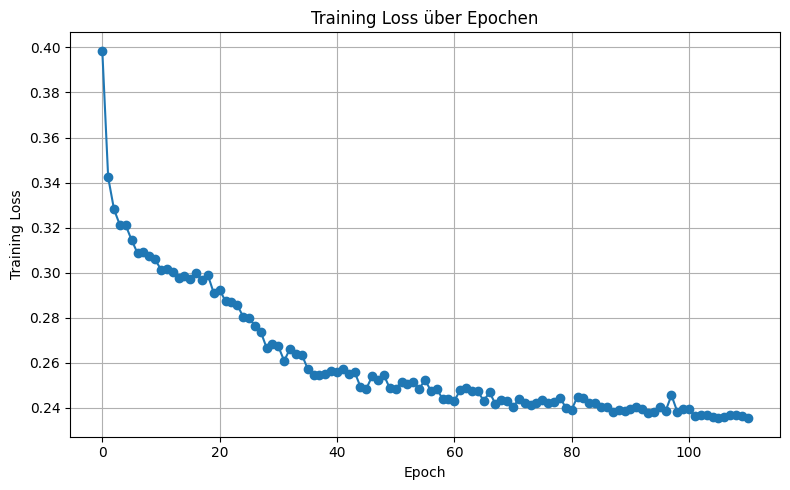

In [360]:
#plot loss over epochs

plt.figure(figsize=(8, 5))
plt.plot(train_losses, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss über Epochen")
plt.grid(True)
plt.tight_layout()
plt.show()


# Evaluation

In [361]:
#Evaluation on test dataset
model.eval()
total_loss = 0.0

with torch.no_grad():
    for lr, gt, input_frames in test_loader:
        lr = lr.to(device)
        gt = gt.to(device)

        # Apply fftshift to input consistently with training
        lr_fft = torch.fft.fftshift(torch.fft.fft2(lr.squeeze(1)), dim=(-2, -1))
        lr_real_imag = torch.stack([lr_fft.real, lr_fft.imag], dim=1)
        
        # model prediction
        pred_real_imag = model(lr_real_imag)
        pred_complex = torch.complex(pred_real_imag[:,0], pred_real_imag[:,1])

        # Apply ifftshift before ifft2 to revert the shift done on input
        pred_complex_unshifted = torch.fft.ifftshift(pred_complex, dim=(-2, -1))
        pred_spatial = torch.fft.ifft2(pred_complex_unshifted).real.unsqueeze(1)

        # Spatial loss function
        loss = SSIM_Loss(gt, pred_spatial)
        total_loss += loss.item()

avg_loss = total_loss / len(test_loader)
print(f"Test Loss (SSIM): {avg_loss:.6f}")

Test Loss (SSIM): 0.368902


## Plot

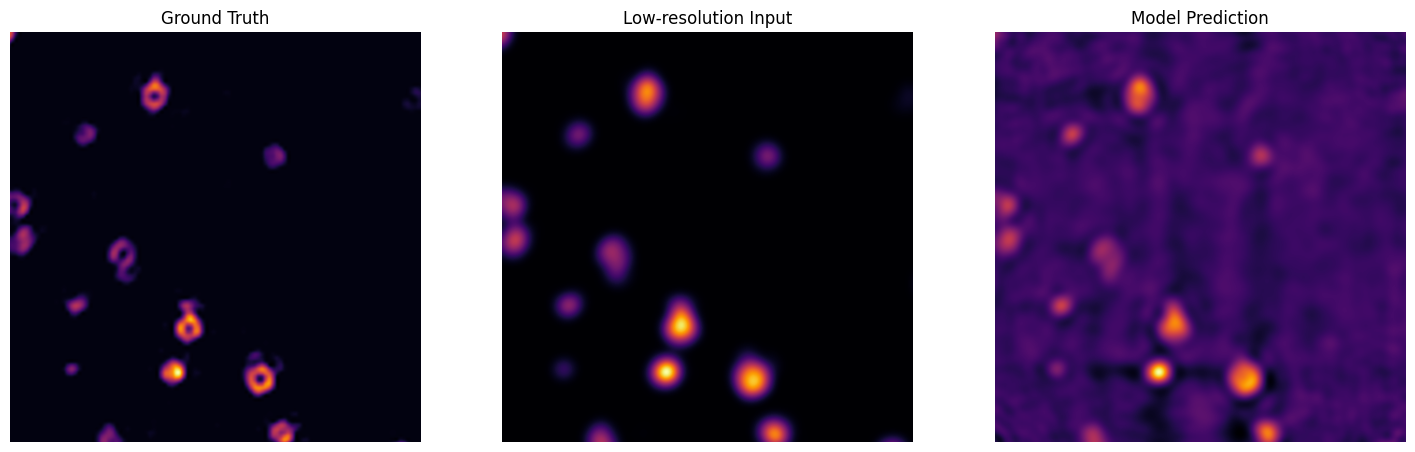

In [362]:


# Pick sample from test loader
lr, gt, input_frames = next(iter(test_loader))  # first batch
lr = lr[0:1].to(device)        # first sample from the batch
gt = gt[0:1].to(device)        # first sample from the batch

# Prepare Frequency Domain Input
lr_fft = torch.fft.fft2(lr.squeeze(1))                  # (1,H,W)
lr_real_imag = torch.stack([lr_fft.real, lr_fft.imag], dim=1)  # (1,2,H,W)

# Model prediction
model.eval()
with torch.no_grad():
    pred_real_imag = model(lr_real_imag)               # (1,2,H,W)
    pred_complex = torch.complex(pred_real_imag[:,0], pred_real_imag[:,1])
    pred_spatial = torch.fft.ifft2(pred_complex).real.unsqueeze(1)  # (1,1,H,W)

# NumPy Arrays for plot
lr_np = lr.squeeze(0).squeeze(0).cpu().numpy()
gt_np = gt.squeeze(0).squeeze(0).cpu().numpy()
pred_np = pred_spatial.squeeze(0).squeeze(0).cpu().numpy()

# Cropping
crop = 20
lr_np = lr_np[crop:-crop, crop:-crop]
gt_np = gt_np[crop:-crop, crop:-crop]
pred_np = pred_np[crop:-crop, crop:-crop]

# Normalize to range [0,1]
def norm01(x):
    return (x - x.min()) / (x.max() - x.min() + 1e-8)

lr_np = norm01(lr_np)
gt_np = norm01(gt_np)
pred_np = norm01(pred_np)

# Plot
plt.figure(figsize=(18,6))

plt.subplot(1,3,1)
plt.imshow(gt_np, cmap='inferno')
plt.title('Ground Truth')
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(lr_np, cmap='inferno')
plt.title('Low-resolution Input')
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(pred_np, cmap='inferno')
plt.title('Model Prediction')
plt.axis('off')

plt.show()


In [363]:
# Pick several samples for plotting

test_iter = iter(test_loader)

selected_indices = [0, 1, 10, 11, 20, 21, 30, 31]  # Indices in test_dataset

samples_to_plot = []

for i in range(max(selected_indices)+1):
    lr, gt, input_frames = next(test_iter)
    
    if i in selected_indices:
        lr = lr.to(device)
        gt = gt.to(device)
        samples_to_plot.append((i, lr, gt))




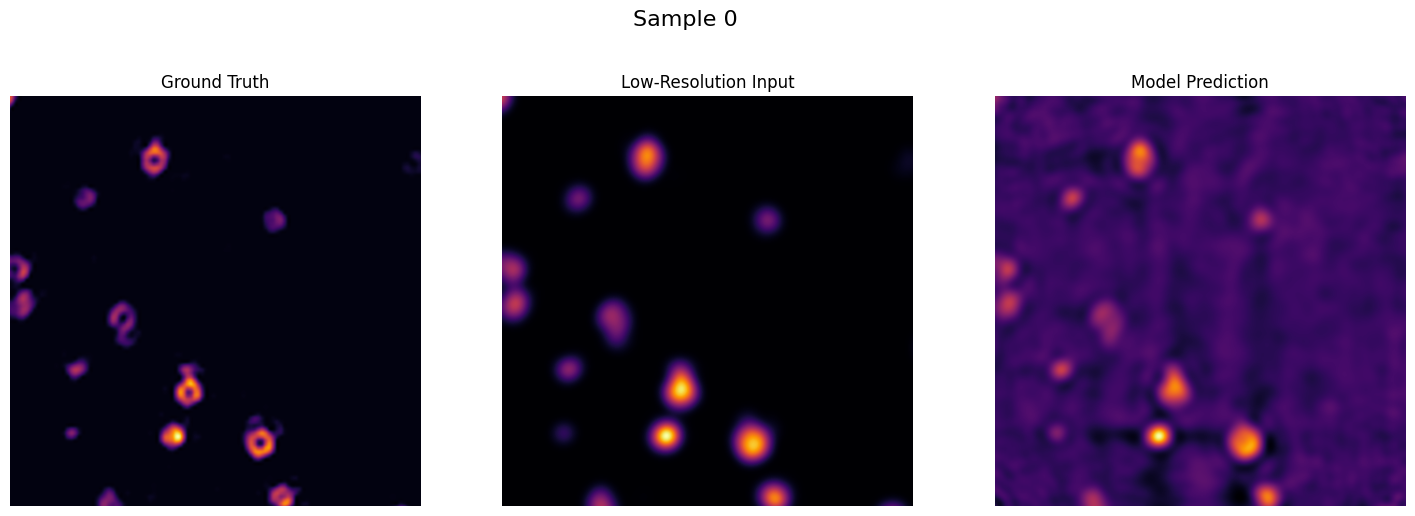

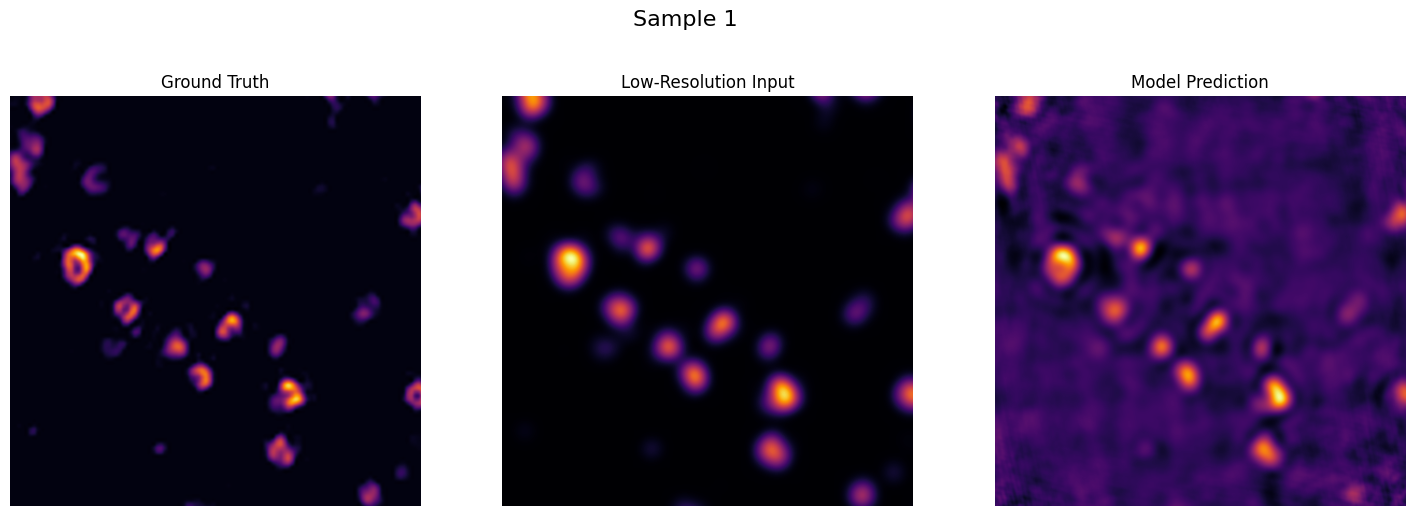

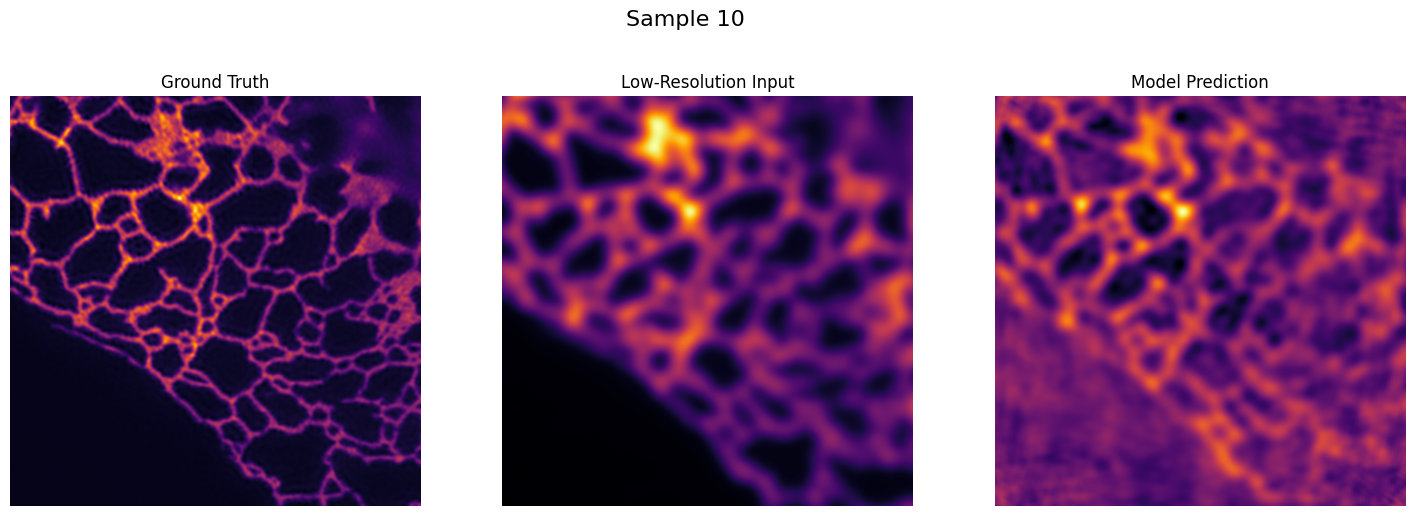

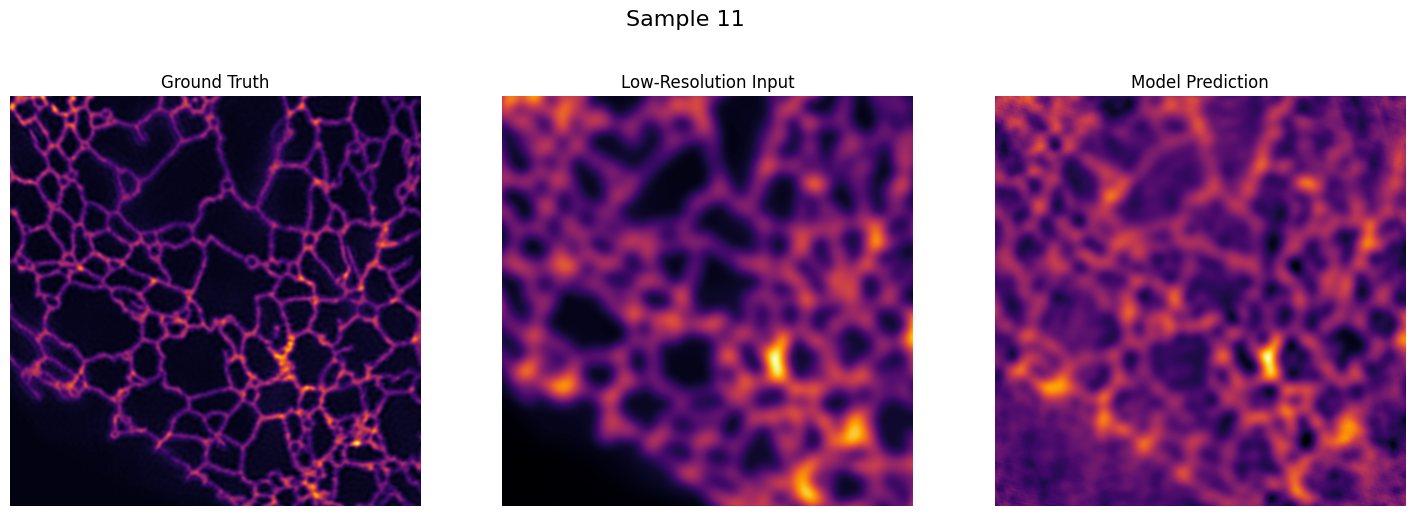

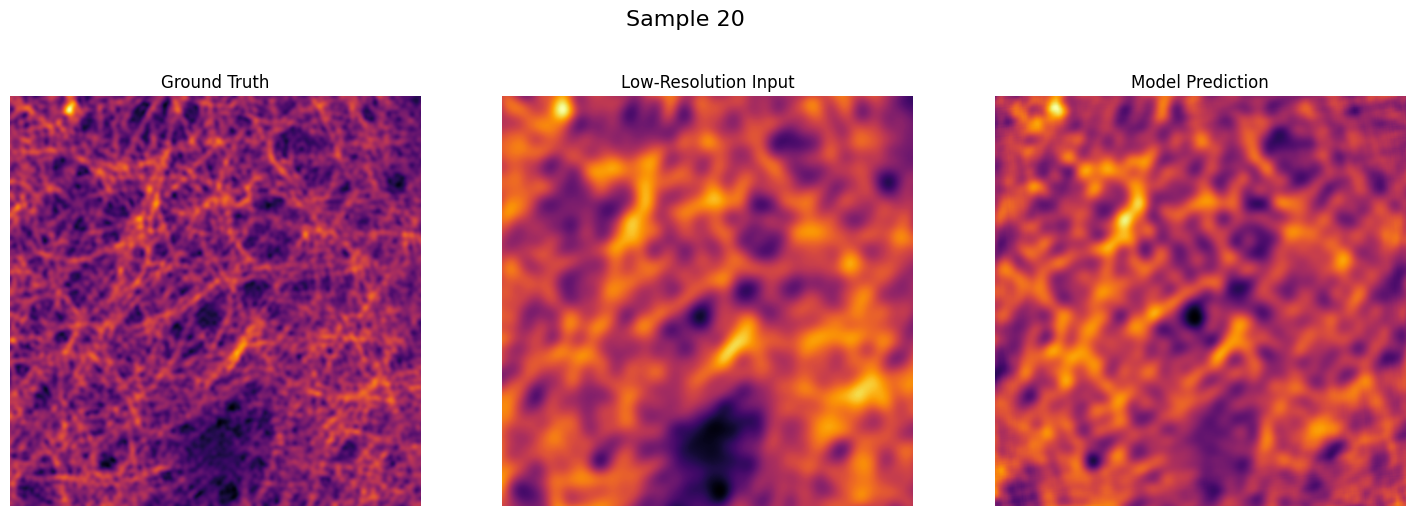

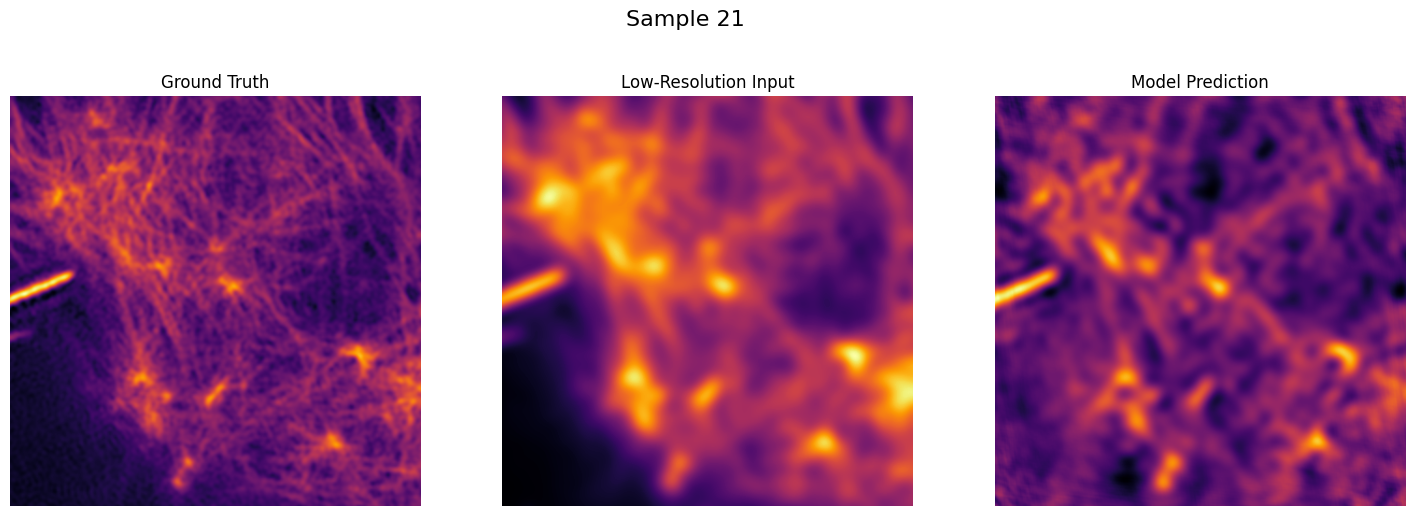

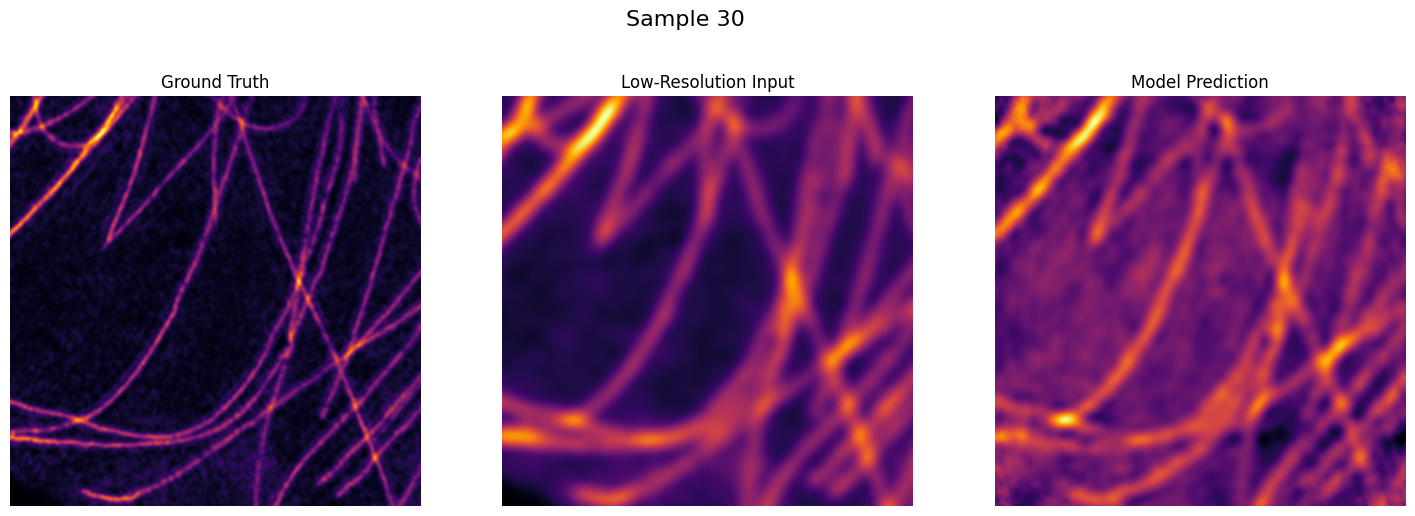

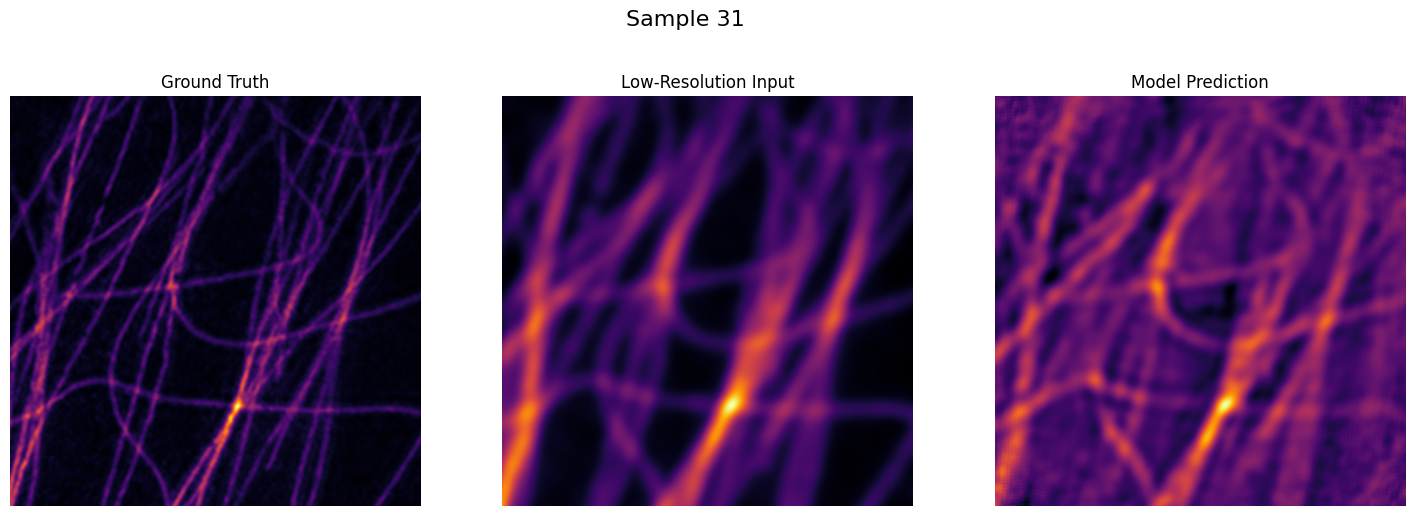

In [364]:
# Plot selection of samples

TYPE_NAMES = ["CCP", "ER", "Microtubules", "F-actin"]

for idx, lr, gt in samples_to_plot:

    # Frequency Domain & Model
    lr_fft = torch.fft.fft2(lr.squeeze(1))
    lr_real_imag = torch.stack([lr_fft.real, lr_fft.imag], dim=1)

    model.eval()
    with torch.no_grad():
        pred_real_imag = model(lr_real_imag)
        pred_complex = torch.complex(pred_real_imag[:,0], pred_real_imag[:,1])
        pred_spatial = torch.fft.ifft2(pred_complex).real.unsqueeze(1)

    # NumPy & Crop
    crop = 20
    lr_np = lr.squeeze().cpu().numpy()[crop:-crop, crop:-crop]
    gt_np = gt.squeeze().cpu().numpy()[crop:-crop, crop:-crop]
    pred_np = pred_spatial.squeeze().cpu().numpy()[crop:-crop, crop:-crop]

    # Normalize
    def norm01(x):
        return (x - x.min()) / (x.max() - x.min() + 1e-8)
    lr_np, gt_np, pred_np = map(norm01, [lr_np, gt_np, pred_np])

    # Plot
    plt.figure(figsize=(18,6))
    plt.suptitle(f"Sample {idx}", fontsize=16)

    plt.subplot(1,3,1)
    plt.imshow(gt_np, cmap='inferno')
    plt.title("Ground Truth")
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.imshow(lr_np, cmap='inferno')
    plt.title("Low-Resolution Input")
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.imshow(pred_np, cmap='inferno')
    plt.title("Model Prediction")
    plt.axis("off")

    plt.show()


## Results

Training loss is getting much better in the beginning, but stagnates at above 0.2.
Test loss is worse.
Possible reasons: 
Overfitting. This might be caused by the very limited number of test samples.
Test loss function does not adequately represent the spatial loss.

How do predictions of training data look like if transformed to spatial domain?

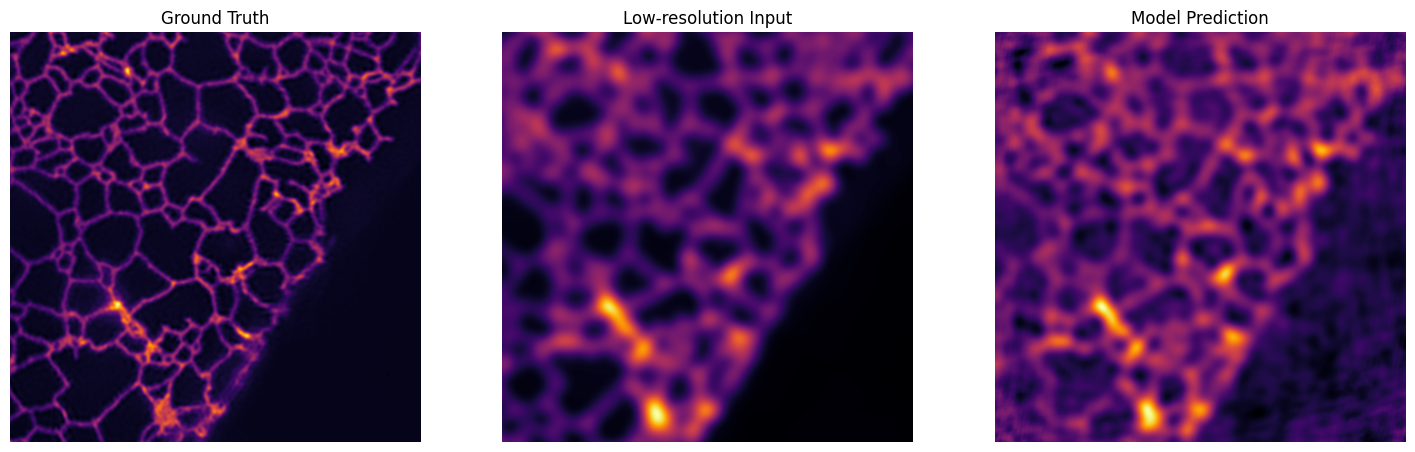

In [365]:
#Plot a training sample and its prediction
lr, gt, input_frames = next(iter(train_loader))  # firsts Batch
lr = lr[0:1].to(device)        # first sample from the batch
gt = gt[0:1].to(device)        # first sample from the batch

# Prepare Frequency Domain Input
lr_fft = torch.fft.fftshift(torch.fft.fft2(lr.squeeze(1)), dim=(-2, -1))                  # (1,H,W)
lr_real_imag = torch.stack([lr_fft.real, lr_fft.imag], dim=1)  # (1,2,H,W)

# Model prediction
model.eval()
with torch.no_grad():
    pred_real_imag = model(lr_real_imag)               # (1,2,H,W)
    pred_complex = torch.complex(pred_real_imag[:,0], pred_real_imag[:,1])
    # Inverse fftshift anwenden, da das Modell mit geshiftetem Input trainiert wurde
    pred_complex_unshifted = torch.fft.ifftshift(pred_complex, dim=(-2, -1))
    pred_spatial = torch.fft.ifft2(pred_complex_unshifted).real.unsqueeze(1)  # (1,1,H,W)

# # NumPy Arrays for plot
lr_np = lr.squeeze(0).squeeze(0).cpu().numpy()
gt_np = gt.squeeze(0).squeeze(0).cpu().numpy()
pred_np = pred_spatial.squeeze(0).squeeze(0).cpu().numpy()

# Cropping
crop = 20
lr_np = lr_np[crop:-crop, crop:-crop]
gt_np = gt_np[crop:-crop, crop:-crop]
pred_np = pred_np[crop:-crop, crop:-crop]

# Normalize
def norm01(x):
    return (x - x.min()) / (x.max() - x.min() + 1e-8)

lr_np = norm01(lr_np)
gt_np = norm01(gt_np)
pred_np = norm01(pred_np)

# Plot
plt.figure(figsize=(18,6))

plt.subplot(1,3,1)
plt.imshow(gt_np, cmap='inferno')
plt.title('Ground Truth')
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(lr_np, cmap='inferno')
plt.title('Low-resolution Input')
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(pred_np, cmap='inferno')
plt.title('Model Prediction')
plt.axis('off')

plt.show()

## Analysis of the results

Comparison of Ground truth, low resolution input and model prediction in spatial domain and frequency domain.

In [366]:
# Prepare a sample and its prediction

input_type = 'real_imag'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FrequencyUNet(input_type=input_type).to(device)

if os.path.exists(checkpoint_path):
    print("Lade gespeichertes Modell...")
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint["model_state"])
else:
    print("Kein gespeichertes Modell gefunden. Das Modell wird ohne geladene Gewichte verwendet.")

model.eval()

# 1. Get a single batch of low-resolution input (lr_batch) and ground truth (gt_batch) from the train_loader.
lr_batch, gt_batch, _ = next(iter(train_loader))

# 2. Select the first sample from the batch for both lr_batch and gt_batch and move them to the appropriate device.
lr = lr_batch[0:1].to(device)
gt = gt_batch[0:1].to(device)

# 3. Prepare the low-resolution input for the model
lr_fft = torch.fft.fftshift(torch.fft.fft2(lr.squeeze(1)), dim=(-2, -1))
lr_real_imag = torch.stack([lr_fft.real, lr_fft.imag], dim=1)

# 4. Generate the model's prediction
with torch.no_grad():
    pred_real_imag = model(lr_real_imag)
    pred_complex = torch.complex(pred_real_imag[:,0], pred_real_imag[:,1])

# 6. Apply an inverse shift
pred_complex_unshifted = torch.fft.ifftshift(pred_complex, dim=(-2, -1))

# 7. Perform an inverse 2D Fast Fourier Transform to obtain the model's spatial prediction
pred_spatial = torch.fft.ifft2(pred_complex_unshifted).real.unsqueeze(1)

print("Low-resolution input shape:", lr.shape)
print("Ground truth shape:", gt.shape)
print("Model prediction (spatial) shape:", pred_spatial.shape)


Lade gespeichertes Modell...
Low-resolution input shape: torch.Size([1, 1, 480, 480])
Ground truth shape: torch.Size([1, 1, 480, 480])
Model prediction (spatial) shape: torch.Size([1, 1, 480, 480])


In [367]:
import numpy as np

def fft_mag(x):
    """
    x: 2D numpy array (H,W) in Spatial Domain
    return: log-magnitude in Frequency Domain
    """
    fft = np.fft.fft2(x)
    fft = np.fft.fftshift(fft)              # Low frequencies in the center of the image
    mag = np.abs(fft)
    mag = np.log1p(mag)                     # Log scaling
    mag = (mag - mag.min()) / (mag.max() - mag.min() + 1e-8)
    return mag


In [368]:
lr_freq   = fft_mag(lr_np)
gt_freq   = fft_mag(gt_np)
pred_freq = fft_mag(pred_np)


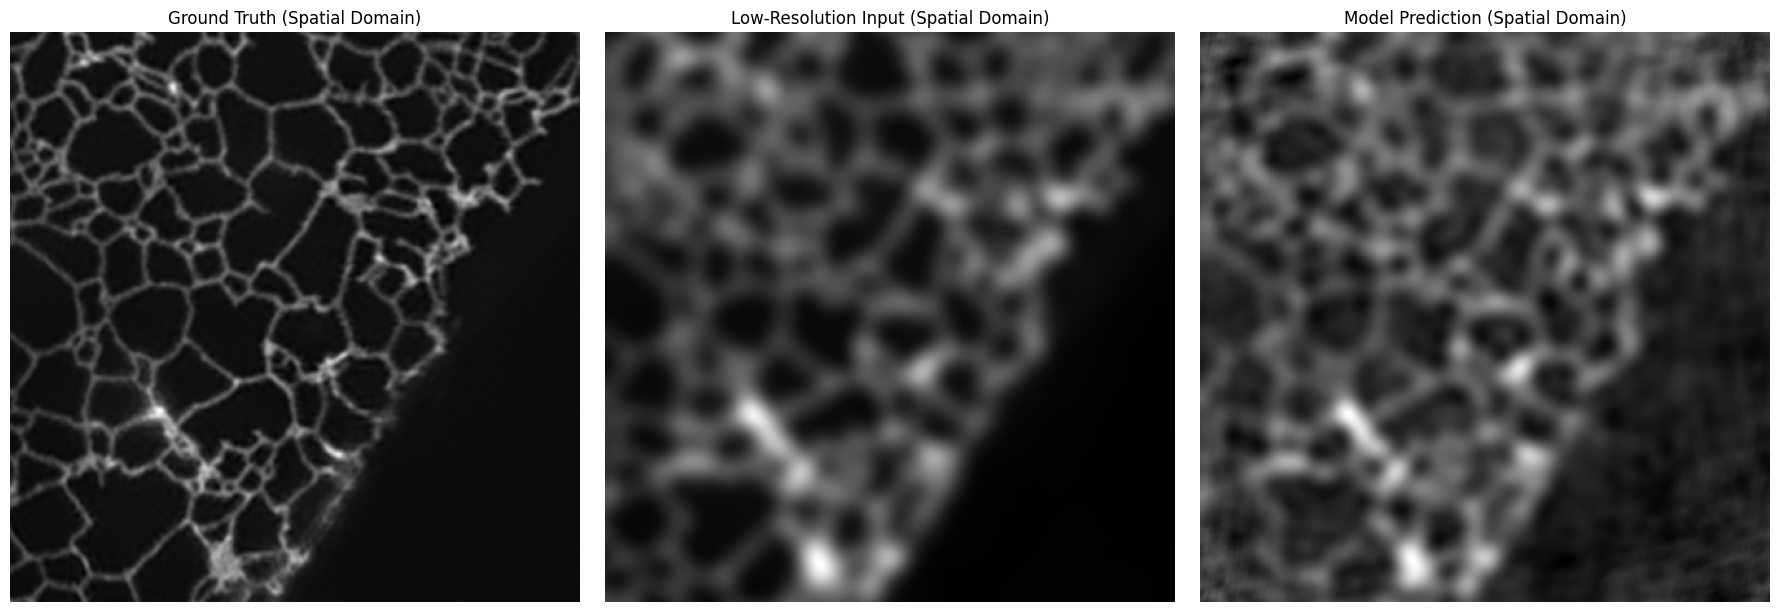

In [369]:
# Plot comparison in spatial domain (as seen before)

plt.figure(figsize=(18, 6))

# --- Ground Truth ---
plt.subplot(1, 3, 1)
plt.imshow(gt_np, cmap='gray')
plt.title('Ground Truth (Spatial Domain)')
plt.axis('off')

# --- Low-Resolution Input ---
plt.subplot(1, 3, 2)
plt.imshow(lr_np, cmap='gray')
plt.title('Low-Resolution Input (Spatial Domain)')
plt.axis('off')

# --- Model Prediction ---
plt.subplot(1, 3, 3)
plt.imshow(pred_np, cmap='gray')
plt.title('Model Prediction (Spatial Domain)')
plt.axis('off')

plt.tight_layout()
plt.show()


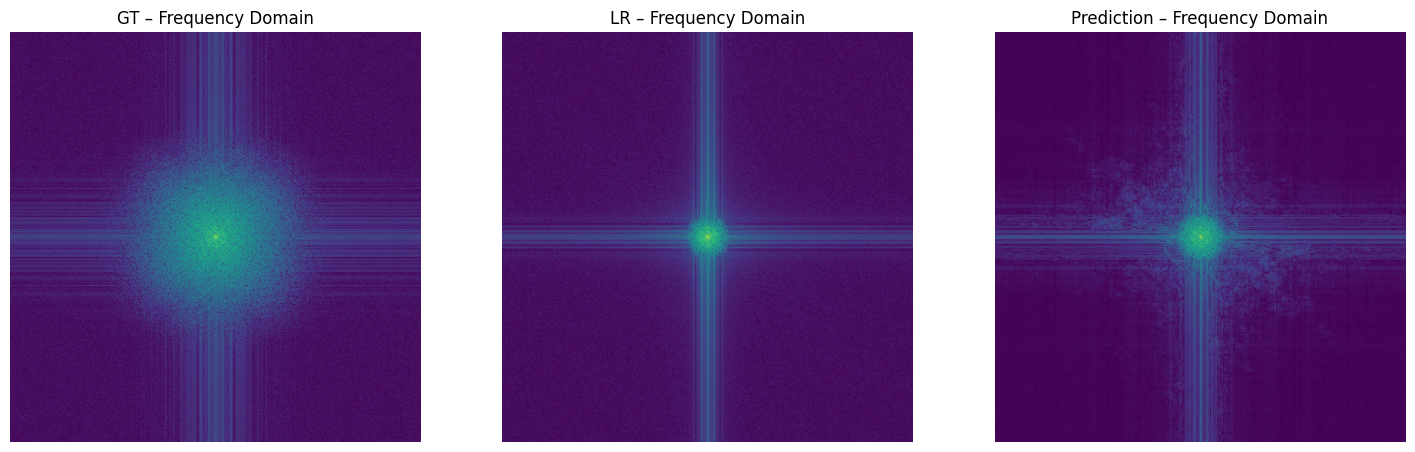

In [370]:
# Plot comparison in frequency domain

plt.figure(figsize=(18,6))

plt.subplot(1,3,1)
plt.imshow(gt_freq, cmap='viridis')
plt.title('GT – Frequency Domain')
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(lr_freq, cmap='viridis')
plt.title('LR – Frequency Domain')
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(pred_freq, cmap='viridis')
plt.title('Prediction – Frequency Domain')
plt.axis('off')

plt.show()


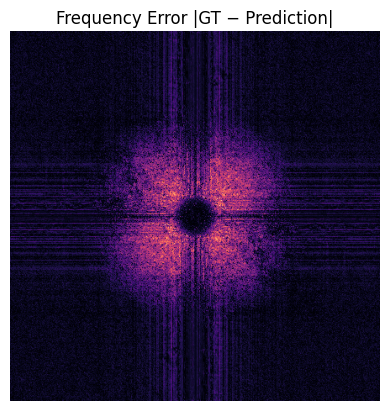

In [371]:
# Plot frequency error

freq_diff = np.abs(gt_freq - pred_freq)

plt.imshow(freq_diff, cmap='magma')
plt.title('Frequency Error |GT − Prediction|')
plt.axis('off')
plt.show()


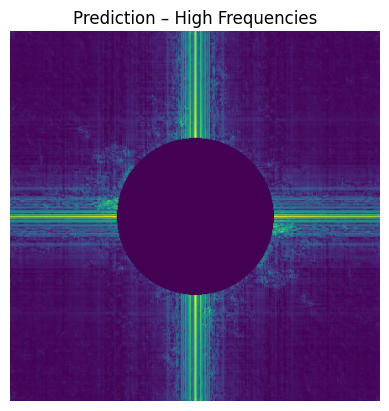

In [372]:
# Plot error in high frequencies

H, W = gt_freq.shape
Y, X = np.ogrid[:H, :W]
center = (H//2, W//2)
radius = np.sqrt((X-center[1])**2 + (Y-center[0])**2)

mask = radius > 0.3 * radius.max()
plt.imshow(pred_freq * mask, cmap='viridis')
plt.title('Prediction – High Frequencies')
plt.axis('off')
plt.show()

## Radial Frequency Profile

In [373]:
def fft_log_magnitude(x):
    fft = np.fft.fft2(x)
    fft = np.fft.fftshift(fft)
    mag = np.abs(fft)
    mag = np.log1p(mag)
    return mag

def radial_profile(mag):
    """
    mag: 2D FFT magnitude (H,W)
    returns: radial mean profile
    """
    H, W = mag.shape
    cy, cx = H // 2, W // 2

    y, x = np.indices((H, W))
    r = np.sqrt((x - cx)**2 + (y - cy)**2)
    r = r.astype(np.int32)

    radial_sum = np.bincount(r.ravel(), mag.ravel())
    radial_count = np.bincount(r.ravel())

    radial_mean = radial_sum / (radial_count + 1e-8)
    return radial_mean


In [374]:
gt_mag   = fft_log_magnitude(gt_np)
lr_mag   = fft_log_magnitude(lr_np)
pred_mag = fft_log_magnitude(pred_np)

gt_rad   = radial_profile(gt_mag)
lr_rad   = radial_profile(lr_mag)
pred_rad = radial_profile(pred_mag)


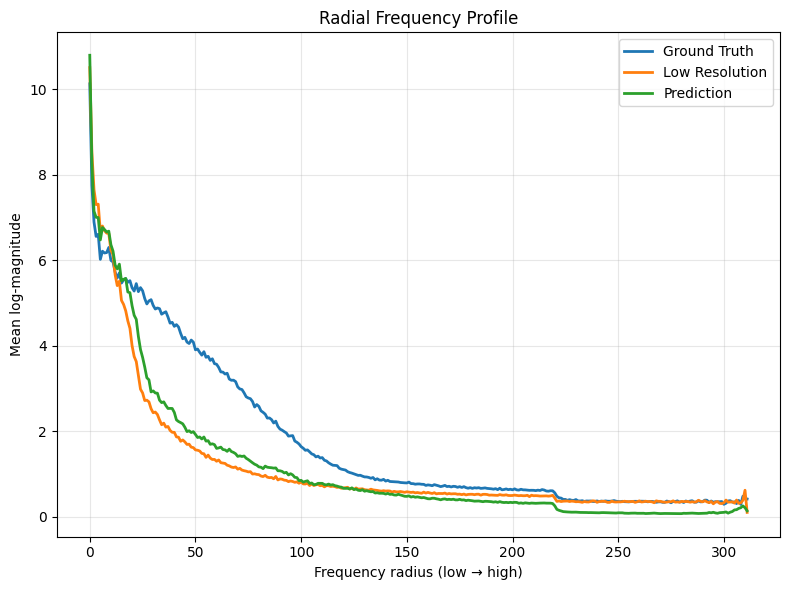

In [375]:
plt.figure(figsize=(8,6))

plt.plot(gt_rad,   label='Ground Truth', linewidth=2)
plt.plot(lr_rad,   label='Low Resolution', linewidth=2)
plt.plot(pred_rad, label='Prediction', linewidth=2)

plt.xlabel('Frequency radius (low → high)')
plt.ylabel('Mean log-magnitude')
plt.title('Radial Frequency Profile')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()


Result: 
In the high and low frequencies, the prediction is close to both  the ground truth and the low resolution (which both are close to each other in those frequencies).
In the medium frequencies, the prediction is closer to the low resolution, but still closer to the ground truth than the low resolution is. 
In contrast, the comparison of the images in the spatial domain shows worse quality of the predicted images (lower resolution, artefacts etc.)
This is probably caused by the deviation of the prediction in the high frequencies, where also small deviations can cause big and visually remarkable differences in the spatial domain.